# Data Intelligence Application
## Pricing + Advertising project ##

Group 17:
* Simone Amadio (C.P. 10499062)
* Elia Broggio (C.P. 10498357)

The goal is modeling a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract. Imagine:
   * one product to sell;
   * three classes of users, where, for every user, we can observe the values of two binary features (feel free to choose the features and their domains); 
   * the conversion rate curve of each class of users;     
   * three subcampaigns, each with a different ad, to advertise the product, and each targeting a different class of users;
   * there are three abrupt phases; 
   * for every abrupt phase and for every subcampaign, the probability distribution over the daily number of clicks for every value of budget allocated to that subcampaign.

### Imagined scenario

#### Product to sell
We imagined a free-to-play game which includes some exclusive features available only for the players who buy the so-called **battle pass**.

#### Classes of users and respective subcampaign
We picked the three following classes of users:

   * *Employed - Adult*: targeted by *Display Advertising*.
   * *Non-employed - Teenager*:  targeted by *Social Advertising*.
   * *Non-employed - Adult*:  targeted by *Search Advertising*.

We didn't consider the class *Employed - Teenager* because we thought this would be the least common class.
  

#### Conversion rate curves
We designed the following 3 curves taking into account the probabilities of each group of users to buy our product.





In [1]:
from tasks.task1 import *
from tasks.task2 import *
from tasks.task34 import *
from tasks.task56 import *

import matplotlib.pyplot as plot
from scipy.interpolate import interp1d

import numpy as np
import random
np.random.seed(2020)
random.seed(20)

environment = EnvironmentManager()

#TOTAL BUDGET OF THE CAMPAIGN
TotBudget = 7
nArms = TotBudget+1
#---------------------------

sampleFactor = 12 #12 samples in a day
horizon = 14 * sampleFactor #Number of sample in a week
NumExperiment = 6

SlidingWindow = 14

NumPeople = 30000

PPW = 5000 #People per week

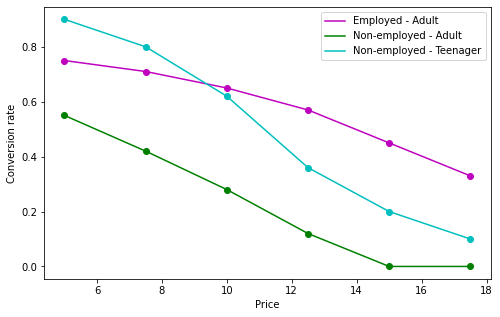

In [6]:
price = environment.prices
categories = environment.categories

labels = {0: "Employed - Adult", 1: "Non-employed - Adult", 2: "Non-employed - Teenager"}
colors = ['m','g','c']

plot.figure(figsize=(8,5))

for i in range(len(categories)):
    prob = environment.probabilities[i]
    smooth = interp1d(price, prob, kind='quadratic')
    plot.plot(price, smooth(price), color=colors[i], label = labels[i])
    plot.scatter(price, prob, color=colors[i])
    plot.xlabel("Price")
    plot.ylabel("Conversion rate")

plot.legend()
plot.show()

#### Abrupt phases
We picked the 3 following phases:

* Working hours: 08-20 during the week (Monday to Friday)
* Non working hours: 20-08 during the week (Monday to Friday)
* Weekend: Saturday and Sunday

We splitted the week in this way because we considered that the three classes of users will act differently with respect to the campaigns.

#### Click functions
For every abrupt phase, the probability distribution over the daily number of clicks changes for every value of budget allocated to each subcampaign.

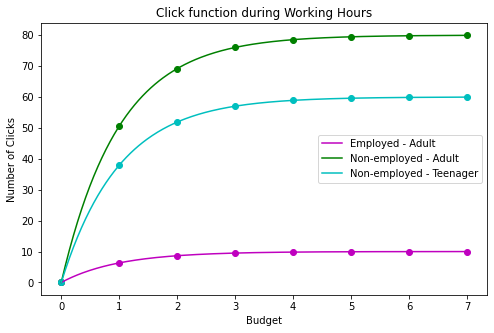

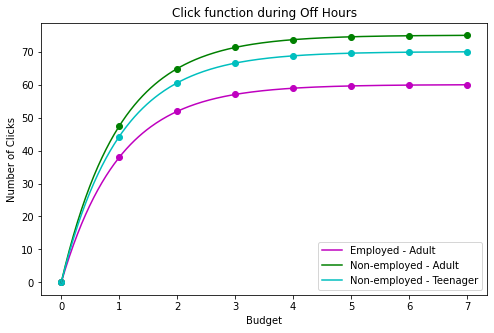

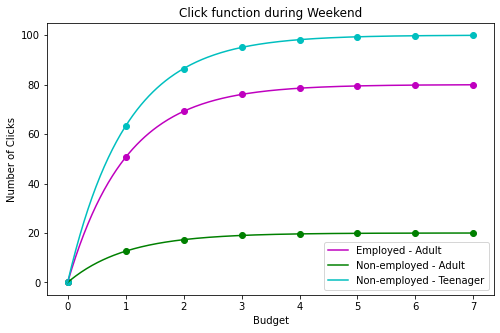

In [7]:
budgets = np.linspace(0, TotBudget, num=nArms)
x = np.linspace(0,max(budgets), num=300)
feature_labels = environment.featureLabels
phase_labels = environment.phaseLabels

for i,label in enumerate(feature_labels):
    plot.figure(figsize=(8,5))
    for j, phase in enumerate(phase_labels):
        y = environment.clickFunctions[label][j](x)
        scatters = environment.clickFunctions[label][j](budgets)
        plot.plot(x, y, color=colors[j], label = labels[j])
        plot.scatter(budgets, scatters, color=colors[j])
        plot.title("Click function during " +phase_labels[i])
        plot.xlabel("Budget")
        plot.ylabel("Number of Clicks")
        plot.legend()

### 1. Design a combinatorial bandit algorithm to optimize the budget allocation over the three subcampaigns to maximize the total number of clicks when, for simplicity, there is only one phase. Plot the cumulative regret.###

First of all, we must run a clairvoyant algorithm to check which is the optimal budget allocaion for the 3 subcampaigns.
The clairvoyant solution subdivide the cumulative daily budget over the 3 subcampaigns, in order to found out the highest number of clicks. In this case we used the **'Knapsack algorithm'**: 

In [8]:
task1 = Task1(TotBudget, nArms)
task1.RunClairvoyant()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,Budget
C0,0.000,31.155,42.616,46.832,48.383,48.954,49.164,49.241,2
C1,0.000,43.120,58.982,64.818,66.965,67.755,68.045,68.152,3
C2,0.000,40.636,55.586,61.085,63.108,63.853,64.126,64.227,2


Given this optimal budget allocation, we can now design our combinatorial bandit algorithm.

We designed a **Combinatorial Gaussian-Process Bandit Algorithm** for every subcampaign, using the Knapsack algorithm as combinatorial constraint. By using GPs, we can significantly reduce the number of samples required to learn the click-function curves because, given a set of samples in the 2D space (budget, clicks), a GP is able to provide a probability distribution over the results.
In a combinatorial GP bandits algorithm, considering that our arms are correlated and the reward of an arm provides information on the reward of the arms close to it, it's possible to pull any set of arms satisfying some combinatorial constraint.

**GP-TS algorithm**

At every time $t$
 1. For every arm *$a$*
 
      $\tilde{\theta}_{a} \leftarrow Sample(\mathbb P(\mu_{a}={\theta}_{a}))$
      
      
 2. Play arm *$a_{t}$* such that
 
      $a_{t} \leftarrow arg max \left\{ \tilde{\theta}_{a} \right\}$
 
 
 3. Update the GP according to the observed


To obtain a more precise result we performed multiple experiments and we averageed the estimated click values.

These are the results for the cumulative regret and the reward over our time horizon (a week).

012345 


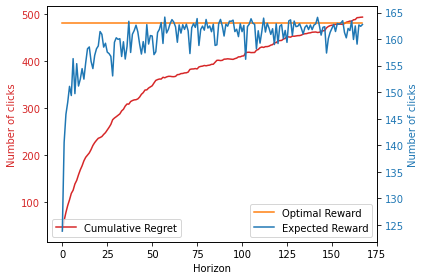

In [9]:
task1.Run(NumExperiment, horizon)

### 2. Design a sliding-window combinatorial bandit algorithm for the case, instead, in which there are the three phases aforementioned. Plot the cumulative regret and compare it with the cumulative regret that a non-sliding-window algorithm would obtain.###

Our environment is now divided into **three phases** (working hours, non-working hours and weekend) that composes the abrupt changes spread over the week. Without using a **sliding-window algorithm**, our task would fail because their bounds will monotonically reduce.
Instead, by using a sliding-window, we can 'forget' the old samples just by uppdating the GP according only to the last observed rewards.

After several run, we agreed that a good size for the sliding window is 14.

012345 


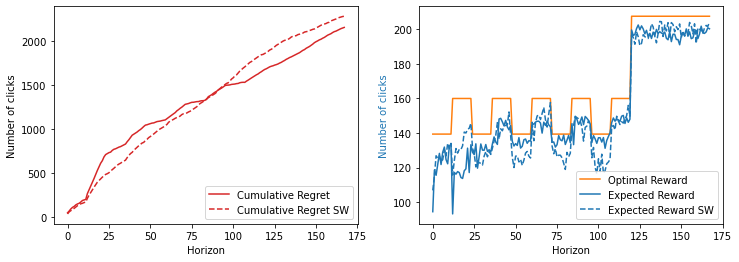

In [4]:
task2 = Task2(TotBudget, nArms, sampleFactor)
task2.Run(NumExperiment, horizon, SlidingWindow)

### 3. Design a learning algorithm for pricing when the users that will buy the product are those that have clicked on the ads. Assume that the allocation of the budget over the three subcampaigns is fixed and there is only one phase (make this assumption also in the next steps). Plot the cumulative regret.### 

For the pricing part, we used a **Thompson Sampling** algorithm:

At every time $t$
 1. For every arm *$a$*
 
      $\tilde{\theta}_{a} \leftarrow Sample(\mathbb P(\mu_{a}={\theta}_{a}))$
      
      
 2. Play arm *$a_{t}$* such that
 
      $a_{t} \leftarrow arg max \left\{ \tilde{\theta}_{a} \right\}$
 
 
 3. Update the Beta distribution of arm *$a_{t}$* as 
     
       $(\alpha_{a_{t}}, \beta_{a_{t}}) ← (\alpha_{a_{t}}, \beta_{a_{t}}) + (x_{a_{t},t}, 1 − x_{a_{t},t})$
       
       
The algorithm will learn a Beta Distributions for each price, adjusting the relative parameters $\alpha_{price}$ and $\beta_{price}$ with the outcomes of the proposed price.

E0: 
15561 successi su 30000 Con: 1 contexts
E1: 
15480 successi su 30000 Con: 1 contexts
E2: 
15609 successi su 30000 Con: 1 contexts
E3: 
15673 successi su 30000 Con: 1 contexts
E4: 
15340 successi su 30000 Con: 1 contexts
E5: 
15442 successi su 30000 Con: 1 contexts


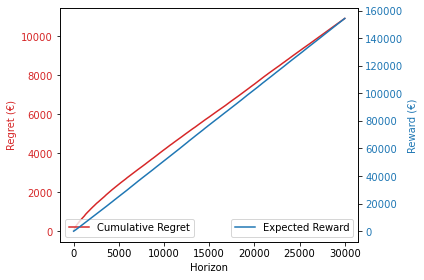

In [4]:
task34 = Task34()
task34.Run(NumExperiment, NumPeople, week=-1)

It's possible to notice how the growth of the regret is **linear**. This happens because there is only one context that handles every class of users.

### 4. Design and run a context generation algorithm for the pricing when the budget allocated to each single subcampaign is fixed. At the end of every week, use the collected data to generate contexts and then use these contexts for the following week. Plot the cumulative regret as time increases.### 

In this case, we applied context generation in order to evaluate whether partitioning is better than not doing that. The space of features is split into different contexts if it respect the split condition: $p_{c_{1}}\mu_{a^{*}_{c1},c1} + p_{c_{2}}\mu_{a^{*}_{c2},c2} \geq \mu_{a^{*}_{c0},c0}$

E0: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 10000, numero di contexts: 3
16144 successi su 30000 Con: 3 contexts
E1: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 10000, numero di contexts: 3
15748 successi su 30000 Con: 3 contexts
E2: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 10000, numero di contexts: 3
15813 successi su 30000 Con: 3 contexts
E3: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 15000, numero di contexts: 3
15707 successi su 30000 Con: 3 contexts
E4: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 10000, numero di contexts: 3
15721 successi su 30000 Con: 3 contexts
E5: 
Context split con successo a t= 5000, numero di contexts: 2
Context split con successo a t= 10000, numero di contexts: 3
16312 successi su 30000 Con: 3 contexts


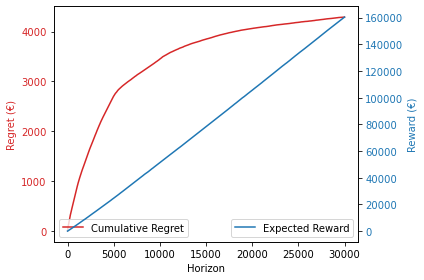

In [5]:
task34.Run(NumExperiment, NumPeople, week=PPW)

In this case, it's possible to notice how the growth of the regret is no more linear. This happens beacuse now, every 5000 people, the context manager has the faculty to split the context. In our case this happens twice (at 5000 an 10000 people).
This seems reasonable because after we split two times, we have 3 contexts that match the number of classes.

### 5. Design an optimization algorithm combining the allocation of budget and the pricing when the seller a priori knows that every subcampaign is associated with a different context and charges a different price for every context.### 

As suggested, we decomposed the two problems since we assume that the classes of users in the pricing algorithm are known and each subcampaign targets a single class of users. That's the reason why we initialize the context manager with 3 contexts.

The algorithm consist of a combination of the algorithm used in the previous points with the difference that here we used the product of number of clicks and expected rewards as value-per-click in the knapsack optimization algorithm. The second term is computed by the pricing algorithm at each round of the budget allocation. It considers as users the number of people (clicks) given by the expected values of the learners of the advertising algorithm.

E0: Price 1: 12.5; Reward: 7.34 Total reward: 347.97 Price 2: 7.5; Reward: 3.17 Total reward: 191.34 Price 3: 10.0; Reward: 6.26 Total reward: 354.89
E1: Price 1: 12.5; Reward: 6.85 Total reward: 320.15 Price 2: 7.5; Reward: 3.13 Total reward: 187.04 Price 3: 10.0; Reward: 6.24 Total reward: 337.87
E2: Price 1: 12.5; Reward: 7.12 Total reward: 311.61 Price 2: 7.5; Reward: 3.10 Total reward: 181.50 Price 3: 10.0; Reward: 6.21 Total reward: 395.53
E3: Price 1: 12.5; Reward: 7.05 Total reward: 314.24 Price 2: 7.5; Reward: 3.16 Total reward: 128.76 Price 3: 10.0; Reward: 6.26 Total reward: 386.29
E4: Price 1: 12.5; Reward: 7.14 Total reward: 302.44 Price 2: 7.5; Reward: 3.15 Total reward: 185.26 Price 3: 10.0; Reward: 6.27 Total reward: 395.23
E5: Price 1: 12.5; Reward: 7.14 Total reward: 321.52 Price 2: 7.5; Reward: 3.17 Total reward: 190.91 Price 3: 10.0; Reward: 6.15 Total reward: 335.54


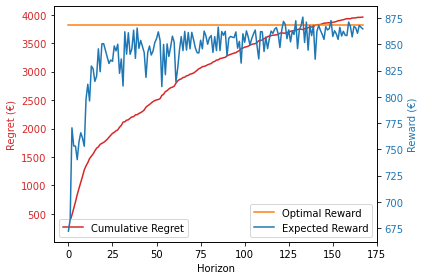

In [2]:
task56 = Task56(TotBudget, nArms, singlePrice=False)
task56.Run(NumExperiment, horizon)

Having the possibility to assign a price to a single class of users, the algorithm computed that the optimal prices for each class of users is respectively 12.5, 7.5 and 10.

### 6. Do the same of Step 6 under the constraint that the seller charges a unique price to all the classes of users. ### 

In this case, the algorithm is the same as before but the same price is assigned to any class of users.
We repeat the knapsack optimization as many times as we have values of price, using the expected rewards of the corresponding price for each class of users as value-per-click in each knapsack input table. We choose the value of price that maximize the sum of the output values of the knapsack.

E0: Price: 10.0; Rewards: 6.35 Total reward: 271.08, 2.95 Total reward: 167.55, 6.28 Total reward: 398.41
E1: Price: 10.0; Rewards: 6.32 Total reward: 281.89, 2.22 Total reward: 127.36, 6.21 Total reward: 335.53
E2: Price: 10.0; Rewards: 6.53 Total reward: 306.45, 2.92 Total reward: 132.15, 6.28 Total reward: 382.57
E3: Price: 10.0; Rewards: 6.42 Total reward: 280.11, 2.70 Total reward: 161.25, 6.17 Total reward: 365.33
E4: Price: 10.0; Rewards: 6.72 Total reward: 312.72, 2.59 Total reward: 154.78, 6.24 Total reward: 333.43
E5: Price: 10.0; Rewards: 5.96 Total reward: 277.59, 2.53 Total reward: 149.96, 6.22 Total reward: 345.21


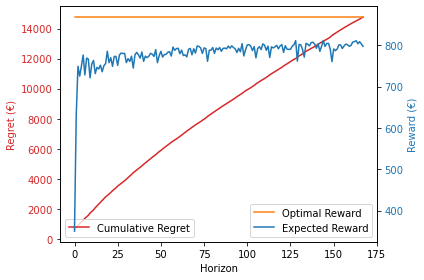

In [3]:
task56 = Task56(TotBudget, nArms, singlePrice=True)
task56.Run(NumExperiment, horizon)

In this case, we can assign a single price to every class of user. The algorithm assign an opimal price of 10.